In [3]:
import pandas as pd
import numpy as np
import os
import gzip
import time
import sys
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import entropy, ks_2samp
from scipy.special import rel_entr



In [131]:
file_path = "/shares/grossniklaus.botinst.uzh/eharputluoglu/data_pub.csv.gz"

df = pd.read_csv(file_path, sep=',')

/sctmp/eharpu/ipykernel_4105256/2732589175.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=',')


In [132]:
df

,chr,start,end,DRR021337_CHG_meth_percent,DRR021337_CHG_Me,DRR021337_CHG_Un,SRR017267_CHG_meth_percent,SRR017267_CHG_Me,SRR017267_CHG_Un,SRR017268_CHG_meth_percent,...,SRR448384_CHG_meth_percent,SRR448384_CHG_Me,SRR448384_CHG_Un,SRR448385_CHG_meth_percent,SRR448385_CHG_Me,SRR448385_CHG_Un,mean_Me,median_Me,mean_Un,median_Un
0,1,31,32,50.0,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,100.0,1.0,0.0,1.250000,1.000000,0.250000,0.000000
1,1,33,34,0.0,0.0,2.0,100.0,1.0,0.0,0.0,...,10.0,1.0,9.0,36.0,4.0,7.0,1.428571,1.000000,2.714286,1.500000
2,1,107,108,83.0,5.0,1.0,0.0,0.0,1.0,0.0,...,100.0,2.0,0.0,100.0,1.0,0.0,1.571429,1.285714,0.428571,0.214286
3,1,113,114,22.0,2.0,7.0,0.0,0.0,2.0,0.0,...,0.0,0.0,2.0,50.0,1.0,1.0,0.714286,0.357143,2.000000,1.500000
4,1,116,117,40.0,2.0,3.0,NaN,NaN,NaN,0.0,...,33.0,5.0,10.0,36.0,7.0,12.0,2.833333,2.000000,5.000000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5946350,Pt,153639,153640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,1.0,0.000000,0.000000,1.000000,1.000000
5946351,Pt,153646,153647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,1.0,0.000000,0.000000,1.000000,1.000000
5946352,Pt,153651,153652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,1.0,0.000000,0.000000,1.000000,1.000000
5946353,Pt,153692,153693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,1.0,0.000000,0.000000,1.000000,1.000000


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5946355 entries, 0 to 5946354
Data columns (total 33 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   chr                          object 
 1   start                        int64  
 2   end                          int64  
 3   DRR021337_CHG_meth_percent   float64
 4   DRR021337_CHG_Me             float64
 5   DRR021337_CHG_Un             float64
 6   SRR017267_CHG_meth_percent   float64
 7   SRR017267_CHG_Me             float64
 8   SRR017267_CHG_Un             float64
 9   SRR017268_CHG_meth_percent   float64
 10  SRR017268_CHG_Me             float64
 11  SRR017268_CHG_Un             float64
 12  SRR017269_CHG_meth_percent   float64
 13  SRR017269_CHG_Me             float64
 14  SRR017269_CHG_Un             float64
 15  SRR1565344_CHG_meth_percent  float64
 16  SRR1565344_CHG_Me            float64
 17  SRR1565344_CHG_Un            float64
 18  SRR2064658_CHG_meth_percent  float64
 19  

In [ ]:
import pandas as pd
import numpy as np
import os
import gzip
import time
from scipy.spatial.distance import jensenshannon

############# Smoothing Function ###################
def laplace_smoothing(data, alpha=1e-10):
    return (data + alpha) / (np.sum(data) + alpha * len(data))

############# Calculate JSD #######################
def calculate_jsd(df):
    jsd_results = []

    for index, row in df.iterrows():
        start_time = time.time()

        # Prepare data for mean
        mean_data = np.array([row['mean_Me'], row['mean_Un']])
        smoothed_mean_data = laplace_smoothing(mean_data)
        p_mean_methylated = smoothed_mean_data[0]
        p_mean_unmethylated = smoothed_mean_data[1]

        # Prepare data for median
        median_data = np.array([row['median_Me'], row['median_Un']])
        smoothed_median_data = laplace_smoothing(median_data)
        p_median_methylated = smoothed_median_data[0]
        p_median_unmethylated = smoothed_median_data[1]

        # Prepare data for all values
        all_methylated = np.array([row[f'{sample}_Me'] for sample in df.columns if sample.endswith('_Me')])
        all_unmethylated = np.array([row[f'{sample}_Un'] for sample in df.columns if sample.endswith('_Un')])
        all_methylated = laplace_smoothing(all_methylated)
        all_unmethylated = laplace_smoothing(all_unmethylated)

        # Prepare data for sum
        sum_data = np.array([row['methylated_sum'], row['unmethylated_sum']])
        smoothed_sum_data = laplace_smoothing(sum_data)
        p_sum_methylated = smoothed_sum_data[0]
        p_sum_unmethylated = smoothed_sum_data[1]

        # Calculate JSDs (always methylated vs unmethylated)
        jsd_mean = jensenshannon([p_mean_methylated], [p_mean_unmethylated])
        jsd_median = jensenshannon([p_median_methylated], [p_median_unmethylated])
        jsd_all = jensenshannon(all_methylated, all_unmethylated)
        jsd_sum = jensenshannon([p_sum_methylated], [p_sum_unmethylated])

        end_time = time.time()
        time_elapsed = end_time - start_time

        jsd_results.append([row['chr'], row['start'], row['end'], row['mean_Me'], row['mean_Un'], 
                            row['median_Me'], row['median_Un'], jsd_mean, jsd_median, jsd_all, 
                            jsd_sum, time_elapsed])

    jsd_df = pd.DataFrame(jsd_results, columns=['chr', 'start', 'end', 'mean_Me', 'mean_Un', 
                                                'median_Me', 'median_Un', 'jsd_mean', 
                                                'jsd_median', 'jsd_all', 'jsd_sum', 'time'])
    return jsd_df




############# Main Processing Function ###################
def process_and_analyze_file(input_file, output_path):
    try:
        with gzip.open(input_file, 'rt') as f:
            df = pd.read_csv(f)

        # Calculate the sum of methylated and unmethylated counts across all samples
        df['methylated_sum'] = df[[col for col in df.columns if col.endswith('_Me')]].sum(axis=1)
        df['unmethylated_sum'] = df[[col for col in df.columns if col.endswith('_Un')]].sum(axis=1)

        # Calculate JSDs
        jsd_df = calculate_jsd(df)

        # Save results
        jsd_df.to_csv(output_path, index=False, compression='gzip')
        print(f"Output successfully saved to {output_path}")
    except Exception as e:
        print(f"Error processing file {input_file}: {e}")

############# Main Script Entry ###################
if __name__ == "__main__":
    import sys
    if len(sys.argv) != 3:
        print("ARGS is not equal to 3! USE: python run.py <input_file.csv.gz> <output_file.csv.gz>")
        sys.exit(1)

    input_file = sys.argv[1]
    output_file = sys.argv[2]

    process_and_analyze_file(input_file, output_file)


In [47]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon

# Laplace smoothing function with increased alpha
def laplace_smoothing(data, alpha=1e-8):
    return (data + alpha) / (np.sum(data) + alpha * len(data))

# Function to calculate JSD
def calculate_jsd(df):
    jsd_results = []

    for index, row in df.iterrows():
        # Prepare data for mean
        mean_data = np.array([row['mean_Me'], row['mean_Un']])
        smoothed_mean_data = laplace_smoothing(mean_data)

        # Prepare data for median
        median_data = np.array([row['median_Me'], row['median_Un']])
        smoothed_median_data = laplace_smoothing(median_data)

        # Prepare data for all values
        all_methylated = []
        all_unmethylated = []

        for sample in df.columns:
            if sample.endswith('_Me'):
                all_methylated.append(row[sample])
            elif sample.endswith('_Un'):
                all_unmethylated.append(row[sample])

        all_methylated = laplace_smoothing(np.array(all_methylated))
        all_unmethylated = laplace_smoothing(np.array(all_unmethylated))

        # Prepare data for sum
        sum_data = np.array([row['methylated_sum'], row['unmethylated_sum']])
        smoothed_sum_data = laplace_smoothing(sum_data)

        # Calculate JSDs (always methylated vs unmethylated)
        jsd_mean = jensenshannon(smoothed_mean_data, smoothed_mean_data[::-1])
        jsd_median = jensenshannon(smoothed_median_data, smoothed_median_data[::-1])
        jsd_all = jensenshannon(all_methylated, all_unmethylated)
        jsd_sum = jensenshannon(smoothed_sum_data, smoothed_sum_data[::-1])

        jsd_results.append([row['chr'], row['start'], row['end'], row['mean_Me'], row['mean_Un'], 
                            row['median_Me'], row['median_Un'], jsd_mean, jsd_median, jsd_all, 
                            jsd_sum])

    jsd_df = pd.DataFrame(jsd_results, columns=['chr', 'start', 'end', 'mean_Me', 'mean_Un', 
                                                'median_Me', 'median_Un', 'jsd_mean', 
                                                'jsd_median', 'jsd_all', 'jsd_sum'])
    return jsd_df

# Ensure there are no NaNs in the data
df = df.fillna(0)

# Calculate sum of methylated and unmethylated counts
df['methylated_sum'] = df[[col for col in df.columns if col.endswith('_Me')]].sum(axis=1)
df['unmethylated_sum'] = df[[col for col in df.columns if col.endswith('_Un')]].sum(axis=1)

# Run the JSD calculation
jsd_results_df = calculate_jsd(df)  # Testing with the first 100 rows

# View the results
jsd_results_df.head()


/home/eharpu/data/conda/envs/environment_shannon/lib/python3.12/site-packages/scipy/spatial/distance.py:1272: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


,chr,start,end,mean_Me,mean_Un,median_Me,median_Un,jsd_mean,jsd_median,jsd_all,jsd_sum
0,1,31,32,1.250000,0.250000,1.000000,0.000000,0.492530,0.832554,0.607258,0.524951
1,1,33,34,1.428571,2.714286,1.000000,1.500000,0.221272,0.141900,0.489555,0.215663
2,1,107,108,1.571429,0.428571,1.285714,0.214286,0.416614,0.532006,0.587551,0.426186
3,1,113,114,0.714286,2.000000,0.357143,1.500000,0.341779,0.451215,0.499575,0.350202
4,1,116,117,2.833333,5.000000,2.000000,3.000000,0.196865,0.141900,0.230849,0.192251


In [48]:
jsd_results_df.to_csv()

,chr,start,end,mean_Me,mean_Un,median_Me,median_Un,jsd_mean,jsd_median,jsd_all,jsd_sum
0,1,31,32,1.250000,0.250000,1.000000,0.000000,0.492530,0.832554,0.607258,0.524951
1,1,33,34,1.428571,2.714286,1.000000,1.500000,0.221272,0.141900,0.489555,0.215663
2,1,107,108,1.571429,0.428571,1.285714,0.214286,0.416614,0.532006,0.587551,0.426186
3,1,113,114,0.714286,2.000000,0.357143,1.500000,0.341779,0.451215,0.499575,0.350202
4,1,116,117,2.833333,5.000000,2.000000,3.000000,0.196865,0.141900,0.230849,0.192251
...,...,...,...,...,...,...,...,...,...,...,...
5946350,Pt,153639,153640,0.000000,1.000000,0.000000,1.000000,0.832554,0.832554,0.584820,0.832555
5946351,Pt,153646,153647,0.000000,1.000000,0.000000,1.000000,0.832554,0.832554,0.584820,0.832555
5946352,Pt,153651,153652,0.000000,1.000000,0.000000,1.000000,0.832554,0.832554,0.584820,0.832555
5946353,Pt,153692,153693,0.000000,1.000000,0.000000,1.000000,0.832554,0.832554,0.584820,0.832555


In [4]:
file_path = '/shares/grossniklaus.botinst.uzh/eharputluoglu/jsd_results.csv'
jsd_results_df.to_csv(file_path, index=False)

NameError: name 'jsd_results_df' is not defined

In [53]:
df = jsd_results_df
df

,chr,start,end,mean_Me,mean_Un,median_Me,median_Un,jsd_mean,jsd_median,jsd_all,jsd_sum,ratio
0,1,31,32,1.250000,0.250000,1.000000,0.000000,0.492530,0.832554,0.607258,0.524951,0.833333
1,1,33,34,1.428571,2.714286,1.000000,1.500000,0.221272,0.141900,0.489555,0.215663,0.344828
2,1,107,108,1.571429,0.428571,1.285714,0.214286,0.416614,0.532006,0.587551,0.426186,0.785714
3,1,113,114,0.714286,2.000000,0.357143,1.500000,0.341779,0.451215,0.499575,0.350202,0.263158
4,1,116,117,2.833333,5.000000,2.000000,3.000000,0.196865,0.141900,0.230849,0.192251,0.361702
...,...,...,...,...,...,...,...,...,...,...,...,...
5946350,Pt,153639,153640,0.000000,1.000000,0.000000,1.000000,0.832554,0.832554,0.584820,0.832555,0.000000
5946351,Pt,153646,153647,0.000000,1.000000,0.000000,1.000000,0.832554,0.832554,0.584820,0.832555,0.000000
5946352,Pt,153651,153652,0.000000,1.000000,0.000000,1.000000,0.832554,0.832554,0.584820,0.832555,0.000000
5946353,Pt,153692,153693,0.000000,1.000000,0.000000,1.000000,0.832554,0.832554,0.584820,0.832555,0.000000


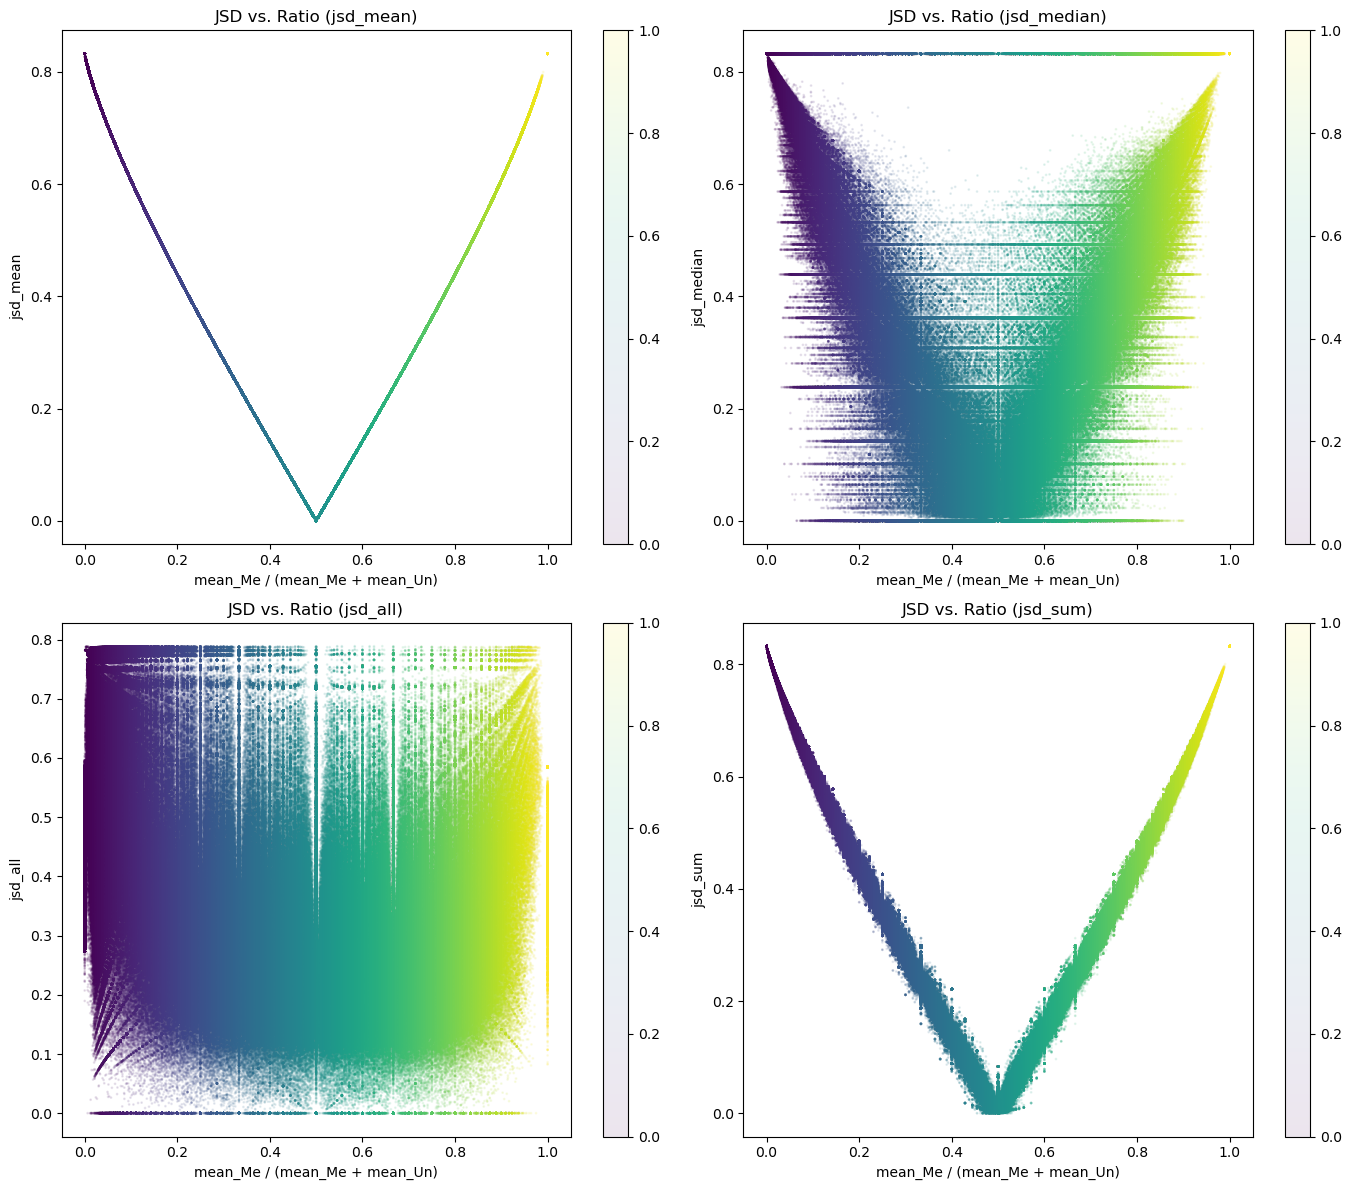

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#df['ratio'] = df['mean_Me'] / (df['mean_Me'] + df['mean_Un'])

fig, axs = plt.subplots(2, 2, figsize=(14, 12))

sc1 = axs[0, 0].scatter(df['ratio'], df['jsd_mean'], c=df['ratio'], cmap='viridis', alpha=0.1, s=1)
axs[0, 0].set_title('JSD vs. Ratio (jsd_mean)')
axs[0, 0].set_xlabel('mean_Me / (mean_Me + mean_Un)')
axs[0, 0].set_ylabel('jsd_mean')
fig.colorbar(sc1, ax=axs[0, 0])

sc2 = axs[0, 1].scatter(df['ratio'], df['jsd_median'], c=df['ratio'], cmap='viridis', alpha=0.1, s=1)
axs[0, 1].set_title('JSD vs. Ratio (jsd_median)')
axs[0, 1].set_xlabel('mean_Me / (mean_Me + mean_Un)')
axs[0, 1].set_ylabel('jsd_median')
fig.colorbar(sc2, ax=axs[0, 1])

sc3 = axs[1, 0].scatter(df['ratio'], df['jsd_all'], c=df['ratio'], cmap='viridis', alpha=0.1, s=1)
axs[1, 0].set_title('JSD vs. Ratio (jsd_all)')
axs[1, 0].set_xlabel('mean_Me / (mean_Me + mean_Un)')
axs[1, 0].set_ylabel('jsd_all')
fig.colorbar(sc3, ax=axs[1, 0])

sc4 = axs[1, 1].scatter(df['ratio'], df['jsd_sum'], c=df['ratio'], cmap='viridis', alpha=0.1, s=1)
axs[1, 1].set_title('JSD vs. Ratio (jsd_sum)')
axs[1, 1].set_xlabel('mean_Me / (mean_Me + mean_Un)')
axs[1, 1].set_ylabel('jsd_sum')
fig.colorbar(sc4, ax=axs[1, 1])

plt.tight_layout()
plt.show()


In [5]:
df_ = pd.read_csv("/shares/grossniklaus.botinst.uzh/eharputluoglu/meth1001_code_DKT/analysis/14_shannonData_JSD/output/SRR1565344_CHG.bedGraph.gz/output.csv.gz")

/sctmp/eharpu/ipykernel_342961/218270211.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.read_csv("/shares/grossniklaus.botinst.uzh/eharputluoglu/meth1001_code_DKT/analysis/14_shannonData_JSD/output/SRR1565344_CHG.bedGraph.gz/output.csv.gz")


In [6]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570367 entries, 0 to 570366
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   chr                 570367 non-null  object 
 1   start               570367 non-null  int64  
 2   end                 570367 non-null  int64  
 3   total_methylated    570367 non-null  float64
 4   total_unmethylated  570367 non-null  float64
 5   jsd_all             570367 non-null  float64
 6   jsd_mean            570365 non-null  float64
 7   jsd_sum             570367 non-null  float64
 8   time                570367 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 39.2+ MB


In [23]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon

# Extend the data to include 100 positions with random counts
np.random.seed(42)  # For reproducibility
n_positions = 100

# Create synthetic data
positions = [f'Position{i+1}' for i in range(n_positions)]
samples = [f'Sample{i+1}' for i in range(10)]
features = ['Feature1', 'Feature2']

data = {
    (sample, feature): np.random.randint(0, 7, n_positions)
    for sample in samples for feature in features
}

# Create DataFrame
indata = pd.DataFrame(data, index=positions)
indata.columns = pd.MultiIndex.from_tuples(indata.columns, names=['Sample', 'Feature'])

# Sum by 'Sample' and 'Feature'
count_per_unit = indata.T.groupby(level=0).sum().T  # Sum by 'Sample'
data_feature = indata.T.groupby(level=1).sum().T.astype(np.int32)  # Sum by 'Feature'

# Shannon entropy function
def shannon_entropy(countmatrix):
    count_distribution = countmatrix.sum(axis=1).values[:, np.newaxis]  # Reshape to keep dimensions
    print(count_distribution)
    prob = countmatrix / count_distribution
    entropy = -np.sum(prob * np.log(prob + 1e-9), axis=1)  # Adding a small value to avoid log(0)
    return entropy

# Custom JSD calculation
def js_divergence(indata):
    mix_entropy = shannon_entropy(data_feature)
    avg_entropy = np.mean([shannon_entropy(indata.xs(sample, axis=1, level='Sample')) for sample in indata.columns.levels[0]], axis=0)
    
    jsd = (mix_entropy - avg_entropy) * np.log2(np.e)
    
    return pd.DataFrame({'JSD_bit_': jsd, 'HMIX_bit_': mix_entropy, 'avg_entropy': avg_entropy}, index=indata.index)

# Library JSD calculation using scipy's Jensen-Shannon
def jsd_scipy(indata):
    jsd_values = []
    
    for idx, row in indata.iterrows():
        distributions = row.values.reshape(len(indata.columns.levels[0]), len(indata.columns.levels[1])).T
        m = distributions.mean(axis=1)
        jsd = np.mean([jensenshannon(d, m, base=2) for d in distributions.T])
        jsd_values.append(jsd)
    
    return pd.DataFrame({'JSD_bit_': jsd_values}, index=indata.index)

# Library JSD alternative calculation
def jsd_scipy_(indata):
    jsd_values = []
    
    for idx, row in indata.iterrows():
        distributions = row.values.reshape(len(indata.columns.levels[0]), len(indata.columns.levels[1])).T
        p, q, r = distributions[:, 0], distributions[:, 1], distributions[:, 2]
        m = 0.5 * (p + q + r)
        jsd = (jensenshannon(p, m, base=2) + jensenshannon(q, m, base=2) + jensenshannon(r, m, base=2)) / 3
        jsd_values.append(jsd)
    
    return pd.DataFrame({'JSD_bit_': jsd_values}, index=indata.index)

# Calculate JSD using both custom and library methods
custom_jsd = js_divergence(indata)
library_jsd = jsd_scipy(indata)

# Comparison of JSD results
comparison = custom_jsd[['JSD_bit_']].join(library_jsd, lsuffix='_custom', rsuffix='_library')

# Display the comparison
print("\nComparison of JSD results:")
print(comparison)



Comparison of JSD results:
             JSD_bit__custom  JSD_bit__library
Position1           0.205446          0.178483
Position2           0.408469          0.287172
Position3           0.252796          0.196923
Position4           0.591561               NaN
Position5           0.256775          0.191817
...                      ...               ...
Position96          0.025532          0.052611
Position97          0.623592               NaN
Position98          0.199049          0.177631
Position99          0.227525          0.198193
Position100         0.350484          0.236794

[100 rows x 2 columns]


/home/eharpu/data/conda/envs/environment_shannon/lib/python3.12/site-packages/scipy/spatial/distance.py:1262: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)


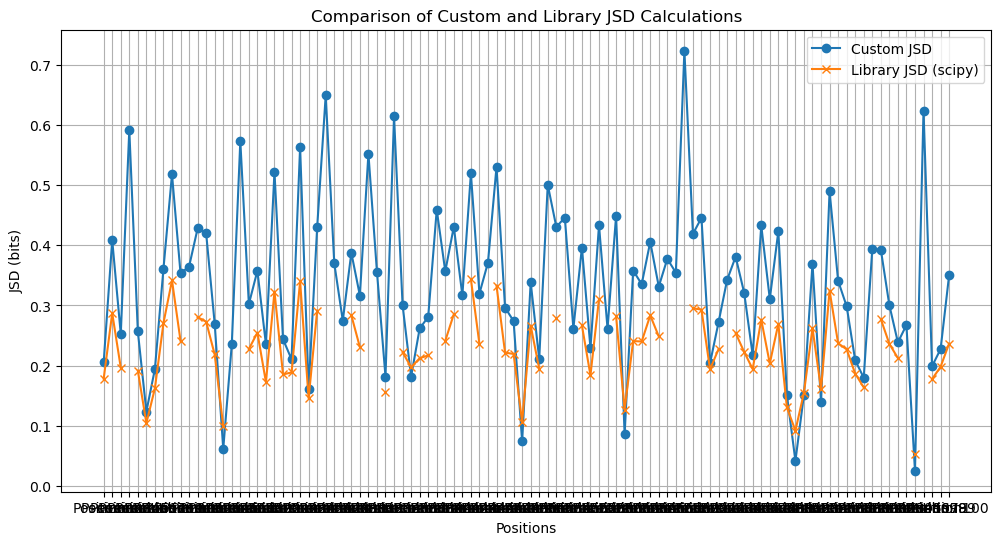

In [8]:
import matplotlib.pyplot as plt

# Assuming 'comparison' DataFrame is already calculated and contains the JSD results

plt.figure(figsize=(12, 6))

# Plotting both JSD results
plt.plot(comparison.index, comparison['JSD_bit__custom'], label='Custom JSD', marker='o')
plt.plot(comparison.index, comparison['JSD_bit__library'], label='Library JSD (scipy)', marker='x')

# Adding labels and title
plt.xlabel('Positions')
plt.ylabel('JSD (bits)')
plt.title('Comparison of Custom and Library JSD Calculations')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()


In [27]:

# Sum by 'Sample' and 'Feature'
count_per_unit = indata.T.groupby(level=0).sum().T  # Sum by 'Sample'
data_feature = indata.T.groupby(level=1).sum().T.astype(np.int32)  # Sum by 'Feature'

# Shannon entropy function
def shannon_entropy(countmatrix): # countmatrix(data_feature) is a df where it shows the toral of metylated and total of um for each row, total is coming from all samples
    # count_distribution = tortal m and um of all samples for each row
    count_distribution = countmatrix.sum(axis=1).values[:, np.newaxis]  # Reshape to keep dimensions
    
    print("count_distribution", count_distribution)

    # prob is total metylated / total (m+um) among all samples
    prob = countmatrix / count_distribution
    print("prob", prob)
    entropy = -np.sum(prob * np.log(prob + 1e-9), axis=1)  # Adding a small value to avoid log(0)
    print("entropy", entropy)
    return entropy

# Custom JSD calculation
def js_divergence(indata):
    #  total entropy of all samples total metyhlated/total (m+um) --> input for entropy
    mix_entropy = shannon_entropy(data_feature)
    # here they calculate sahnnon entropy with all metylation and unmmetylation pairs and then calculate of avg metylation and avg um values of all samples for each row
    avg_entropy = np.mean([shannon_entropy(indata.xs(sample, axis=1, level='Sample')) for sample in indata.columns.levels[0]], axis=0)
    
    jsd = (mix_entropy - avg_entropy) * np.log2(np.e)
    
    return pd.DataFrame({'JSD_bit_': jsd, 'HMIX_bit_': mix_entropy, 'avg_entropy': avg_entropy}, index=indata.index)


custom_jsd = js_divergence(indata)


count_distribution [[22]
 [26]
 [18]]
prob Feature    Feature1  Feature2
Position1  0.545455  0.454545
Position2  0.500000  0.500000
Position3  0.444444  0.555556
entropy Position1    0.689009
Position2    0.693147
Position3    0.686962
dtype: float64
count_distribution [[12]
 [ 5]
 [ 8]]
prob Feature    Feature1  Feature2
Position1       0.5       0.5
Position2       0.6       0.4
Position3       0.5       0.5
entropy Position1    0.693147
Position2    0.673012
Position3    0.693147
dtype: float64
count_distribution [[ 6]
 [12]
 [ 3]]
prob Feature    Feature1  Feature2
Position1  0.666667  0.333333
Position2  0.500000  0.500000
Position3  0.333333  0.666667
entropy Position1    0.636514
Position2    0.693147
Position3    0.636514
dtype: float64
count_distribution [[4]
 [9]
 [7]]
prob Feature    Feature1  Feature2
Position1  0.500000  0.500000
Position2  0.444444  0.555556
Position3  0.428571  0.571429
entropy Position1    0.693147
Position2    0.686962
Position3    0.682908
dtype: flo

In [47]:
a = []
for sample in ['Sample1', 'Sample2', 'Sample3']:
    a += [indata.xs(sample, axis=1, level='Sample')]

In [49]:
m = np.mean(a, axis = 0)

In [50]:
mavg_entropy = np.mean([shannon_entropy(indata.xs(sample, axis=1, level='Sample')) for sample in indata.columns.levels[0]], axis=0)

array([[4.        , 3.33333333],
       [4.33333333, 4.33333333],
       [2.66666667, 3.33333333]])

In [51]:
a

[Feature    Feature1  Feature2
 Position1         6         6
 Position2         3         2
 Position3         4         4,
 Feature    Feature1  Feature2
 Position1         4         2
 Position2         6         6
 Position3         1         2,
 Feature    Feature1  Feature2
 Position1         2         2
 Position2         4         5
 Position3         3         4]

In [44]:
indata

Sample     Sample1           Sample2           Sample3         
Feature   Feature1 Feature2 Feature1 Feature2 Feature1 Feature2
Position1        6        6        4        2        2        2
Position2        3        2        6        6        4        5
Position3        4        4        1        2        3        4

In [58]:
o = indata.values.reshape(
            count_per_unit.shape[0],
            count_per_unit.shape[1],
            data_feature.shape[1])


In [129]:

a


array([[1.05581025, 0.91635252],
       [1.05000405, 1.02531804],
       [0.93131886, 1.02100215]])

In [138]:
aa = np.average(
        shannon_entropy(o),
        weights= a,
        axis=1)


[[[6 6]
  [4 2]
  [2 2]]

 [[3 2]
  [6 6]
  [4 5]]

 [[4 4]
  [1 2]
  [3 4]]]
---------------------
count_distribution [[12 10]
 [13 13]
 [ 8 10]]
---------------------
prob [[[0.5        0.6       ]
  [0.30769231 0.15384615]
  [0.25       0.2       ]]

 [[0.25       0.2       ]
  [0.46153846 0.46153846]
  [0.5        0.5       ]]

 [[0.33333333 0.4       ]
  [0.07692308 0.15384615]
  [0.375      0.4       ]]]
---------------------
entropy [[1.05581025 0.91635252]
 [1.05000405 1.02531804]
 [0.93131886 1.02100215]]
---------------------


In [139]:
aa

array([1.05581025, 1.03766105, 0.93220681])

In [133]:
aa

array([1.05581025, 1.03766105, 0.96121329])

In [79]:
def shannon_entropy(countmatrix): # countmatrix(data_feature) is a df where it shows the toral of metylated and total of um for each row, total is coming from all samples
    # count_distribution = tortal m and um of all samples for each row
    print(countmatrix)
    print("---------------------")
    
    count_distribution = countmatrix.sum(axis=1)# Reshape to keep dimensions
    
    print("count_distribution", count_distribution)
    print("---------------------")

    # prob is total metylated / total (m+um) among all samples
    prob = countmatrix / count_distribution
    print("prob", prob)
    print("---------------------")
    
    entropy = -np.sum(prob * np.log(prob + 1e-9), axis=1)  # Adding a small value to avoid log(0)
    print("entropy", entropy)
    print("---------------------")
    
    return entropy

In [115]:
means = [np.mean(list(d)) for d in count_per_unit.fillna(0).values]

In [107]:
for d in count_per_unit.fillna(0).values:
    print(np.mean(list(d)))
    print("------")

7.333333333333333
------
8.666666666666666
------
6.0
------


In [130]:
count_per_unit.fillna(0).values

array([[12,  6,  4],
       [ 5, 12,  9],
       [ 8,  3,  7]])

In [137]:
a = [[8, 0],
       [1, 1],
       [100, 1]]